In [1]:
!pip install -q dwave-ocean-sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.7/18.7 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.7/223.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.6/305.6 kB 18.4 MB/s eta 0:00:00


In [90]:
import pandas as pd, numpy as np
# from ortools.sat.python import cp_model # MILP
#inputs
nodes = pd.read_excel('route_inputs.xlsx', sheet_name='nodes')
paths = pd.read_excel('route_inputs.xlsx', sheet_name='paths')
n_nodes = len(nodes)
n_paths = len(paths)
print('Nodes =====')
print(nodes)
print('Paths =====')
print(paths)

Nodes =====
   node   description
0     1        origin
1     2  middle point
2     3  middle point
3     4  middle point
4     5  middle point
5     6  middle point
6     7   destination
Paths =====
   node_from  node_to  distance
0          1        2       220
1          1        3       150
2          2        4       650
3          2        5       900
4          4        7       500
5          5        7       400
6          3        6       500
7          6        7       400
8          1        5       640


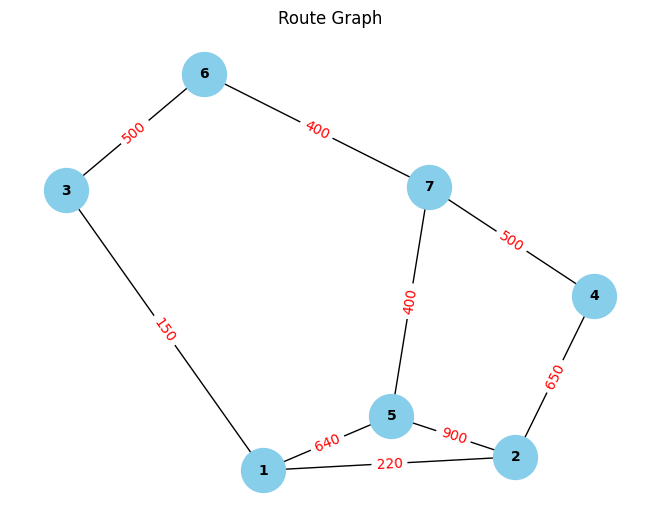

In [91]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
# Create a graph object
G = nx.Graph()

# Add nodes to the graph
for _, node in nodes.iterrows():
    G.add_node(node['node'], label=node['description'])

# Add edges to the graph
for _, path in paths.iterrows():
    G.add_edge(path['node_from'], path['node_to'], weight=path['distance'])

# Draw the graph
pos = nx.spring_layout(G)  # Position nodes using Fruchterman-Reingold force-directed algorithm
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_weight='bold')
edge_labels = {(edge[0], edge[1]): G.edges[edge]['weight'] for edge in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

# Show the graph
plt.title('Route Graph')
plt.show()

In [92]:
x = np.zeros(n_paths).tolist() #it has index of the paths like x[0] for first index i.e. node 1 to 2
x

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [93]:
from dimod import Binary
import neal
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite, FixedEmbeddingComposite, LeapHybridDQMSampler, LeapHybridCQMSampler

x = {}

for p in paths.index:
    x[p] = Binary('x_{}'.format(p))  # Use underscore instead of brackets for naming

print(x) # each index of x like x[[0]] goes 0 to 1 binary variable hence x[[0]](0..1)
 # x[[0]](0..1) means we are taking about index one where node 1 to 2 distance 220 this x[0] value can be 0 or 1
print(x[0])

{0: BinaryQuadraticModel({'x_0': 1.0}, {}, 0.0, 'BINARY'), 1: BinaryQuadraticModel({'x_1': 1.0}, {}, 0.0, 'BINARY'), 2: BinaryQuadraticModel({'x_2': 1.0}, {}, 0.0, 'BINARY'), 3: BinaryQuadraticModel({'x_3': 1.0}, {}, 0.0, 'BINARY'), 4: BinaryQuadraticModel({'x_4': 1.0}, {}, 0.0, 'BINARY'), 5: BinaryQuadraticModel({'x_5': 1.0}, {}, 0.0, 'BINARY'), 6: BinaryQuadraticModel({'x_6': 1.0}, {}, 0.0, 'BINARY'), 7: BinaryQuadraticModel({'x_7': 1.0}, {}, 0.0, 'BINARY'), 8: BinaryQuadraticModel({'x_8': 1.0}, {}, 0.0, 'BINARY')}
BinaryQuadraticModel({'x_0': 1.0}, {}, 0.0, 'BINARY')


In [94]:
#objective function
objFun = sum([x[p] * paths.distance[p] for p in paths.index])
print(objFun) # sum of multiplication of each path and weightage

BinaryQuadraticModel({'x_0': 220.0, 'x_1': 150.0, 'x_2': 650.0, 'x_3': 900.0, 'x_4': 500.0, 'x_5': 400.0, 'x_6': 500.0, 'x_7': 400.0, 'x_8': 640.0}, {}, 0.0, 'BINARY')


In [95]:
cqm = dimod.ConstrainedQuadraticModel()

In [96]:
cqm.set_objective(objFun)

In [97]:
#filtering origin and destination node
node_origin = int(nodes.node[nodes.description=='origin'].iloc[0])
node_destination = int(nodes.node[nodes.description=='destination'].iloc[0])
print("========Nodes======= \n",nodes)
print("node_origin",node_origin)
print("node_destination",node_destination)

========Nodes======= 
    node   description
0     1        origin
1     2  middle point
2     3  middle point
3     4  middle point
4     5  middle point
5     6  middle point
6     7   destination
node_origin 1
node_destination 7


In [98]:
print(paths)
# node which are going from first node or origin node
print("===path from origin value===\n",paths[paths.node_from==node_origin]) #node which are going from origin node
print("===path from origin index ==\n", paths.index[paths.node_from==node_origin]) #get the index which are going from origin node
print("-------------------")
print("===path to Destination value===\n",paths[paths.node_to==node_destination]) #node which are going from origin node
print("===path to Destination index ==\n", paths.index[paths.node_to==node_destination]) #get the index which are going from origin node

   node_from  node_to  distance
0          1        2       220
1          1        3       150
2          2        4       650
3          2        5       900
4          4        7       500
5          5        7       400
6          3        6       500
7          6        7       400
8          1        5       640
===path from origin value===
    node_from  node_to  distance
0          1        2       220
1          1        3       150
8          1        5       640
===path from origin index ==
 Index([0, 1, 8], dtype='int64')
-------------------
===path to Destination value===
    node_from  node_to  distance
4          4        7       500
5          5        7       400
7          6        7       400
===path to Destination index ==
 Index([4, 5, 7], dtype='int64')


In [99]:
#constraint where node to destination node should be 1 and node from origin should be 1
cqm.add_constraint(sum([x[p] for p in paths.index[paths.node_from==node_origin]]) == 1, label="xyz") # here p is 0 and 1 index where edge from origin node
cqm.add_constraint(sum([x[p] for p in paths.index[paths.node_to==node_destination]]) == 1, label="abc") # here p is 4 5 and 7 index where edge to destination node

'abc'

In [100]:
#constraint sum(x, in) == sum(x, out) sum of edge going to node should be equal to sum of edge going from node
print("all middle point \n",nodes[nodes.description=='middle point']) # all middle point node index
print("all middle point node index\n",nodes.node[nodes.description=='middle point']) # all middle point node index
for node in nodes.node[nodes.description=='middle point']:
    sum_in = sum([x[p] for p in paths.index[paths.node_to==node]])
    sum_out = sum([x[p] for p in paths.index[paths.node_from==node]])
    constraint_label = f"Sum_in_out_{node}"
    cqm.add_constraint(sum_in - sum_out == 0, label=constraint_label)

all middle point 
    node   description
1     2  middle point
2     3  middle point
3     4  middle point
4     5  middle point
5     6  middle point
all middle point node index
 1    2
2    3
3    4
4    5
5    6
Name: node, dtype: int64


In [108]:
from collections import Counter
#solve
DWavesampler=EmbeddingComposite(DWaveSampler(solver='Advantage_system6.4',token='DEV-081b757ac8fa9601e4fd99a1710375235deaa0c4')) # using Dwave system
# Create an instance of the LeapHybridCQMSampler
sampler = LeapHybridCQMSampler(token='DEV-081b757ac8fa9601e4fd99a1710375235deaa0c4')

# Sample from the CQM
sample = sampler.sample_cqm(cqm, label="Example - TSP Optimization")
# sample.record
# energies = sample.data_vectors['energy']
# mit = max(energies) # taking optimum or minimum energy solution
# print(mit)

# Collect energy values and their occurrences
energies_occurrences = Counter(sample.data_vectors['energy'])
# Find the energy with the highest count (mode)
most_common_energy = energies_occurrences.most_common(1)[0][0]
print("Most common energy:", most_common_energy)
mit=most_common_energy
mit

# #print
# print('status =', solver.StatusName(status))
# print('OF =', solver.ObjectiveValue())

# paths['activated'] = 0
# for p in paths.index:
#     paths.activated[p] = solver.Value(x[p]) # assigning the optimal binary value
# print(paths)
# # show only activated path
# paths[paths.activated==1]

Most common energy: 1040.0


1040.0

In [102]:
energies

array([1040., 1040.,    0., 1040., 1040., 1040., 1040., 1040., 1040.,
          0., 1040., 1040., 1040., 1040.,    0., 1040., 1040., 1040.,
       1040., 1040., 1040., 1040., 1040., 1040., 1040., 1040., 1040.,
          0., 1040., 1040., 1050.,  220., 1040., 1040., 1040., 1040.,
       1040., 1040., 1040., 1040., 1040., 1040., 1040., 1040., 1040.,
       1040., 1040., 1040., 1040., 1040., 1040., 1040., 1040., 1040.,
       1040., 1040., 1040., 1040., 1040., 1040., 1040., 1040., 1040.,
       1040., 1040., 1040., 1040., 1040., 1040., 1040., 1040., 1040.,
       1040., 1040., 1040., 1040., 1040., 1040., 1040., 1040., 1040.,
       1040., 1040., 1040., 1040., 1040., 1040., 1040., 1040., 1040.,
       1040., 1040., 1040., 1040., 1040., 1040., 1040., 1040., 1040.,
       1040., 1040., 1040., 1050., 1050.,    0.,    0.,  150.,  150.,
        150.,  150.,  150.,  150.,  220.,  220.,  400.,  400.,  400.,
        400.,  550.,  550.,  550.,  550.,  550.,  620.,  620.,  620.,
        620.,  620.]

In [109]:
X_list =[]
i=1
for sample, energy, num_occ in sample.data(['sample', 'energy', 'num_occurrences']):
  if (energy==mit and  i > 0):
     X_list.append(list(sample.values()))
     i=i-1

print(X_list)

[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]]


In [110]:

paths['activated'] = 0
print(paths)

   node_from  node_to  distance  activated
0          1        2       220          0
1          1        3       150          0
2          2        4       650          0
3          2        5       900          0
4          4        7       500          0
5          5        7       400          0
6          3        6       500          0
7          6        7       400          0
8          1        5       640          0


In [111]:
X_list

[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]]

In [112]:
for p in paths.index:
    paths.activated[p] = X_list[0][p]  # Assigning the optimal binary value

print(paths)
# Show only activated paths
activated_paths = paths[paths.activated == 1]
print(activated_paths)


   node_from  node_to  distance  activated
0          1        2       220          0
1          1        3       150          0
2          2        4       650          0
3          2        5       900          0
4          4        7       500          0
5          5        7       400          1
6          3        6       500          0
7          6        7       400          0
8          1        5       640          1
   node_from  node_to  distance  activated
5          5        7       400          1
8          1        5       640          1


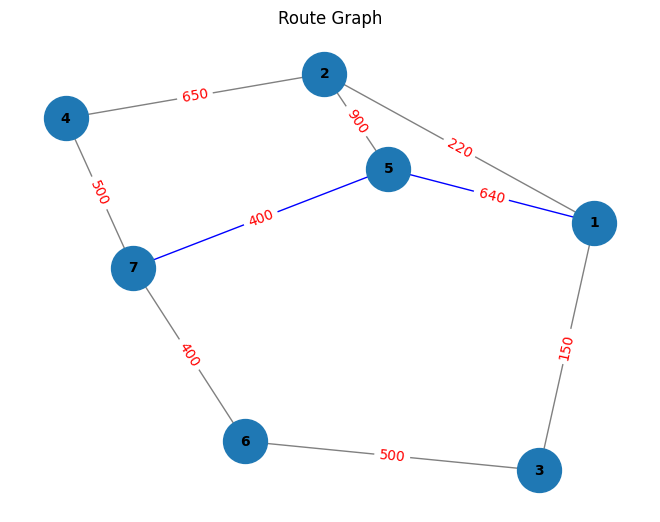

In [113]:
# Finding shortes path in the graph
for _, node in nodes.iterrows():
    G.add_node(node['node'], label=node['description'])

# Add edges to the graph
for _, path in paths.iterrows():
    edge_color = 'blue' if path['activated'] == 1 else 'grey'
    G.add_edge(path['node_from'], path['node_to'], weight=path['distance'], color=edge_color)

# Draw the graph
pos = nx.spring_layout(G)  # Position nodes using Fruchterman-Reingold force-directed algorithm
nx.draw(G, pos, with_labels=True, node_size=1000, font_size=10, font_weight='bold', edge_color=[G[u][v]['color'] for u, v in G.edges])
edge_labels = {(edge[0], edge[1]): G.edges[edge]['weight'] for edge in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

# Show the graph
plt.title('Route Graph')
plt.show()